##Setup & Config

In [1]:
!pip install -q -U watermark

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.19.0

numpy       : 1.19.5
pandas      : 1.1.4
torch       : 1.8.0
transformers: 3.0.0



In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='Paired', font_scale=1.2)

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 21
np.random.seed(RANDOM_SEED)
from pandas import read_csv
import pandas as pd
import numpy as np
import spacy
from sklearn import svm
from sklearn import metrics
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

## Data loading and uniformization of target variable (majortopic)




In [4]:
demo = pd.read_csv("demo.csv")
repu = pd.read_csv("repu.csv")
demo["party"]="demo"
repu["party"]="repu"



In [5]:
demo.head()

,year,id,pap_majortopic,pap_subtopic,majortopic,subtopic,description,filter_democrat,words,party
0,1976,4961,2,202,2,202,We fully recognize the religious and ethical n...,1,20.0,demo
1,1980,5920,2,202,2,202,Reproductive Rights√≠√ØWe fully recognize the ...,1,15.0,demo
2,1980,5921,2,202,2,202,We also recognize the belief of many Americans...,1,23.0,demo
3,1980,5922,2,202,2,202,The Democratic Party supports the 1973 Supreme...,1,29.0,demo
4,1992,9334,2,202,2,202,provide for the full range of reproductive cho...,1,20.0,demo


**I will now add the previous sentence as a new feature**

In [6]:
def add_previous(df):
  df.sort_values(by=['id'],inplace=True)
  df["long_description"] = ""
  for i in range(len(df)):
    if (i==0) or (df["id"][i]==1):
      df["long_description"][i]=str(df["description"][i])
    elif (df["id"][i]-df["id"][i-1]==1) and df["year"][i]==df["year"][i-1]:
      df["long_description"][i]=str(df["description"][i-1])+ "." + str(df["description"][i])
    else:
      df["long_description"][i]=str(df["description"][i])
add_previous(demo)
add_previous(repu)


<ipython-input-6-7eee1a32fe18>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["long_description"][i]=str(df["description"][i])
<ipython-input-6-7eee1a32fe18>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["long_description"][i]=str(df["description"][i])
<ipython-input-6-7eee1a32fe18>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["long_description"][i]=str(df["description"][i-1])+ "." + str(df["description"][i])


In [7]:
platforms=pd.concat([demo,repu])[["description","majortopic","year","party","long_description"]]

In [8]:
len(platforms.majortopic.value_counts())

28

In [9]:
platforms.loc[platforms.majortopic==-555, "majortopic"] = 0

In [10]:
platforms.drop(platforms.loc[platforms['majortopic']==28].index, inplace=True)
platforms.drop(platforms.loc[platforms['majortopic']==31].index, inplace=True)
platforms.drop(platforms.loc[platforms['majortopic']==24].index, inplace=True)
platforms.drop(platforms.loc[platforms['majortopic']==26].index, inplace=True)
platforms.drop(platforms.loc[platforms['majortopic']==27].index, inplace=True)

In [11]:
values=sorted(set(platforms.majortopic))
value_mapping = {}
for idx, value in enumerate(values):
    value_mapping[value] = idx
    
platforms["majortopic"] = np.array(list(map(lambda x: value_mapping[x], platforms["majortopic"])))

In [12]:
class_names = ['No Policy Content', 'Macroeconomics', 'Civil Rights','Health','Agriculture',
               'Labour','Education','Environment','Energy','Immigration','Transportation','Law and Crime',
               'Social Welfare','Housing','Domestic Commerce','Defense','Technology','Foreign Trade',
               'International Affairs','Public Lands','Government Operations', 'Culture'
            ]


**Now I will split the train, test and validation subsets**

In [13]:
platform_number=1
platforms["platform_number"]=0
for party in platforms.party.unique():
  for year in np.sort(platforms[platforms.party==party].year.unique()):
    platforms.loc[(platforms.party==party) & (platforms.year==year) , "platform_number"] = platform_number
    platform_number+=1
  

In [14]:
numbers=[i for i in platforms.platform_number.unique()]
train, test=train_test_split(numbers, test_size=0.20,random_state=RANDOM_SEED)
val,test=train_test_split(test, test_size=0.5,random_state=RANDOM_SEED)
df_train=pd.DataFrame(columns=platforms.columns)
df_test=pd.DataFrame(columns=platforms.columns)
df_val=pd.DataFrame(columns=platforms.columns)
for i in train:
  df_train=pd.concat([df_train, platforms[platforms.platform_number==i]])
for i in test:
  df_test=pd.concat([df_test, platforms[platforms.platform_number==i]])
for i in val:
  df_val=pd.concat([df_val, platforms[platforms.platform_number==i]])

print (df_train.shape, df_val.shape, df_test.shape)


(29945, 6) (3713, 6) (3753, 6)


In [15]:
print(len(train),len(val), len (test))

29 4 4


In [16]:
29945+3713+3753

37411

**Now I will plot the distribution of the test dataset**

In [17]:
df_train.count()

description         29945
majortopic          29945
year                29945
party               29945
long_description    29945
platform_number     29945
dtype: int64

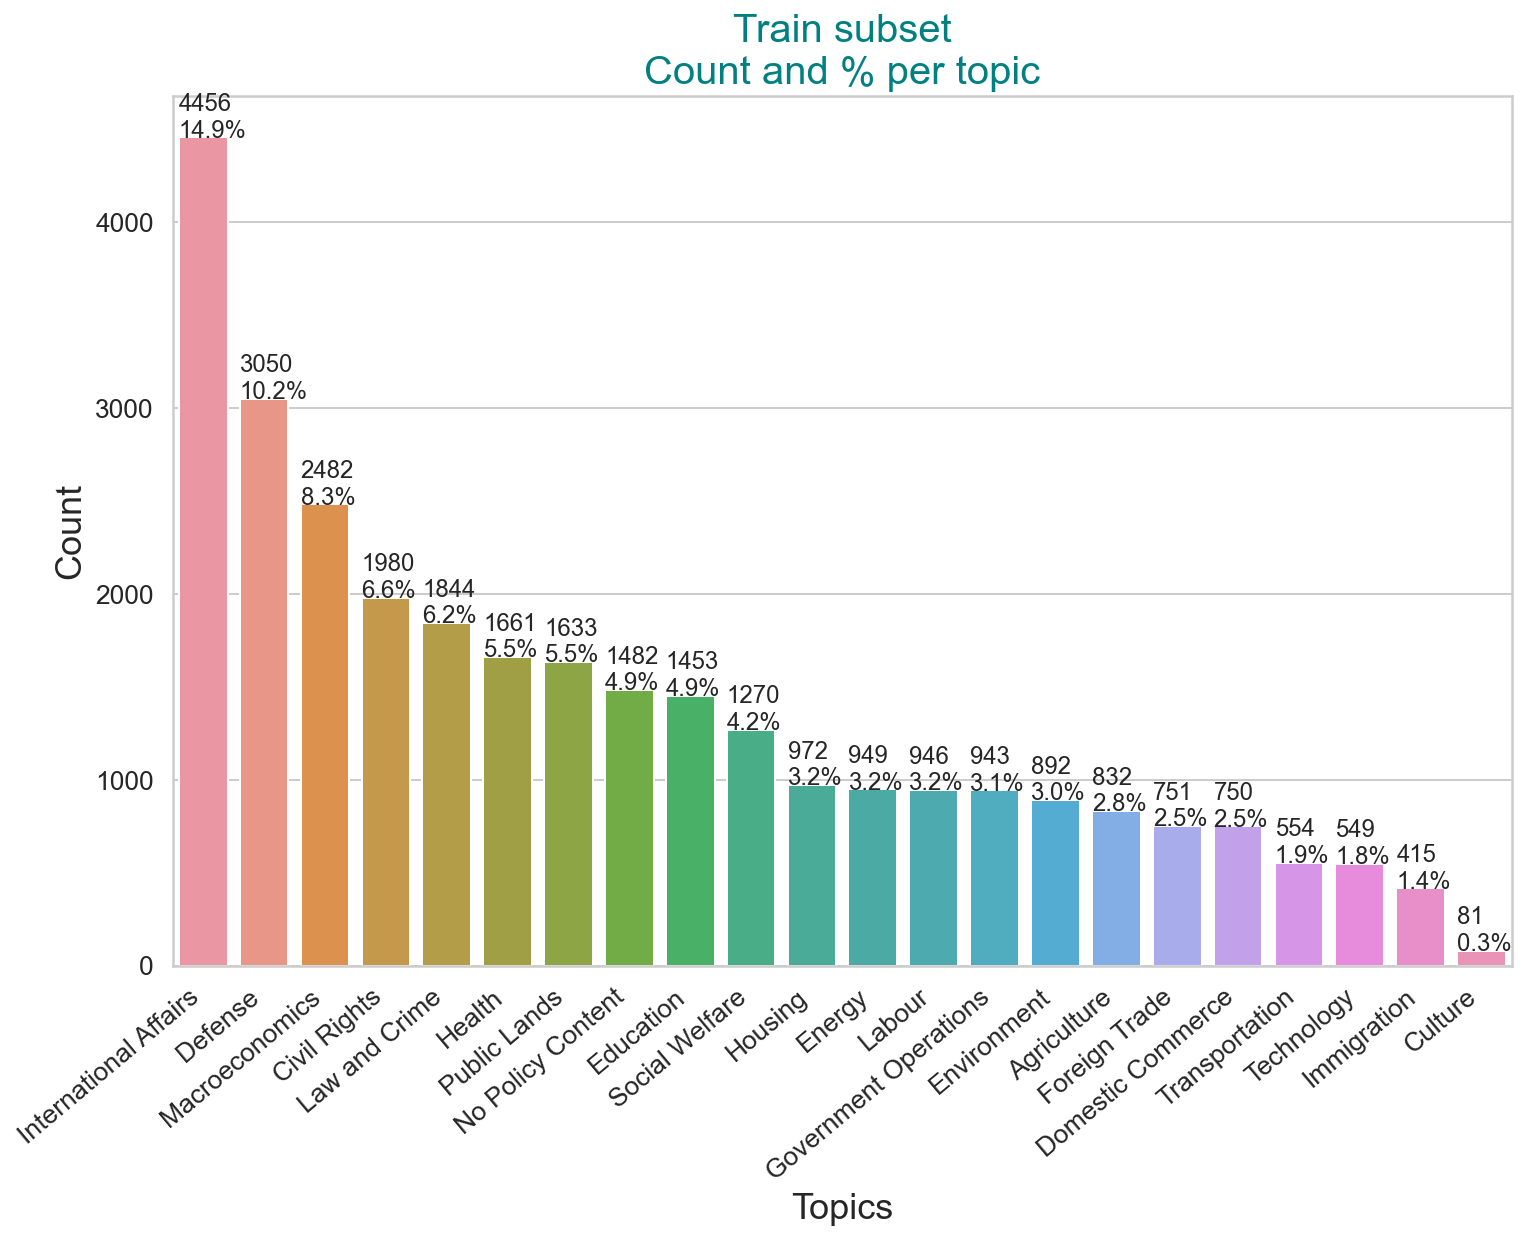

In [18]:
num=[]
percentage=[]
total=df_train.count()[0]
for i in range(len(class_names)):
    a=df_train[df_train.majortopic==i].count()[0]
    num.append(a)
    percentage.append(round(a/total*100,1))
train_counts=pd.DataFrame({"Major_Topic":class_names, "Count":num, "%_of_total":percentage})
sorted_train_counts=train_counts.sort_values("Count",ascending=False)

#And now, the plot:
ax = sns.barplot(x="Major_Topic", y="Count", data=sorted_train_counts)
plt.xlabel('Topics',fontsize =18)
plt.ylabel('Count',fontsize =18)
for p in ax.patches:
    porcentage=p.get_height()/total*100
    txt = str(int(p.get_height()))+"\n" + str((porcentage).round(1)) + "%"
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt, fontsize=12)
plt.title('Train subset\nCount and % per topic', fontsize =20,color="teal")
ax.set_xticklabels(sorted_train_counts.Major_Topic,rotation=40, ha='right');

The topics in the training dataset are really imbalanced, as seen in the chart above, and some topics have a significantly lower number of examples than others. Thus, for those topics that have less than 1000 instances, I  append sentences from a different dataset (US State of the Union) so that the that the training dataset will have at least 1000 examples of each topic. *Note: this is not always possible, as for sometopics there are too few instances both in the training dataset we were using and in the us dataset we are adding rows from.*

In [19]:
us = pd.read_csv("us.csv")[["description","majortopic","year","id"]]
us.drop_duplicates(subset=['id'],inplace=True)
us.majortopic.value_counts()


-555    4221
 19     3233
 1      3231
 16     2922
 20     1145
 3      1037
 6       923
 5       846
 12      830
 13      776
 2       551
 18      538
 8       478
 4       376
 15      362
 7       305
 14      287
 17      285
 9       244
 10      225
 21      205
 23       17
Name: majortopic, dtype: int64

In [20]:
us

,description,majortopic,year,id
0,To the Congress of the United States: A quarte...,1,1946,1
1,Instead it has called on the President to pres...,1,1946,2
2,The Congress has shown its satisfaction with t...,1,1946,3
3,The bigger and more complex the Federal Progra...,1,1946,4
4,"At the same time, it is clear that the budgeta...",1,1946,5
...,...,...,...,...
23039,Our grandest journeys are not yet made.,-555,2020,24227
23040,"The American age, the American epic, the Ameri...",-555,2020,24228
23041,"Our spirit is still young, the Sun is still ri...",-555,2020,24229
23042,"Thank you, God bless you, and God bless America.",-555,2020,24230


In [21]:
us.loc[us.majortopic==-555, "majortopic"] = 0

In [22]:
us.dropna(subset=['description', 'majortopic'],inplace=True)
us=us[us.description!=" "]
us["majortopic"] = np.array(list(map(lambda x: value_mapping[x], us["majortopic"])))

<ipython-input-22-4a66078dd738>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us["majortopic"] = np.array(list(map(lambda x: value_mapping[x], us["majortopic"])))


In [23]:

new_df=pd.DataFrame(columns=df_train.columns)

for i in df_train.majortopic.unique():
    
    current_rows=df_train[df_train.majortopic == i].count().majortopic
    new_df=pd.concat([new_df, df_train[df_train.majortopic == i]])
    if current_rows<1000:
      try:
          adding=us[us.majortopic==i].sample(1000-current_rows,random_state=RANDOM_SEED)
          adding["long_description"]=""
          for index in adding.id:
            previous_sentence=us[us.id==(index-1)].description.values
            adding.loc[adding.id==index, "long_description"] = previous_sentence + "." + us[us.id==(index)].description.values
            
          new_df=pd.concat([new_df, adding])
      except:
          adding=us[us.majortopic==i].copy()
          adding["long_description"]=""
          for index in adding.id:
            previous_sentence=us[us.id==(index-1)].description.values
            try:adding.loc[adding.id==index, "long_description"] = previous_sentence + "." + us[us.id==(index)].description.values
            except:adding.loc[adding.id==index, "long_description"] = us[us.id==(index)].description.values    
          new_df=pd.concat([new_df, adding])


df_train=new_df.copy(deep=True)


In [24]:
df_train[df_train.long_description==""].count()

description         0
majortopic          0
year                0
party               0
long_description    0
platform_number     0
id                  0
dtype: int64

In [25]:
df_train

,description,majortopic,year,party,long_description,platform_number,id
16828,We Believe in America: 2012 REPUBLICAN PLATFORM,0,2012,repu,We Believe in America: 2012 REPUBLICAN PLATFORM,36,NaN
16829,This platform is dedicated with appreciation a...,0,2012,repu,We Believe in America: 2012 REPUBLICAN PLATFOR...,36,NaN
16830,Preamble,0,2012,repu,This platform is dedicated with appreciation a...,36,NaN
16831,The 2012 Republican Platform is a statement of...,0,2012,repu,Preamble.The 2012 Republican Platform is a sta...,36,NaN
16832,The pursuit of opportunity has defined America...,0,2012,repu,The 2012 Republican Platform is a statement of...,36,NaN
...,...,...,...,...,...,...,...
15016,An America where every child can stretch a han...,21,1998,NaN,An America where scientists find cures for dis...,NaN,16211.0
15346,"This year, Hillary and I launched the White Ho...",21,1998,NaN,It just happens once every thousand years..Thi...,NaN,16541.0
15347,"Our culture lives in every community, and ever...",21,1998,NaN,"This year, Hillary and I launched the White Ho...",NaN,16542.0
15348,We should protect them.,21,1998,NaN,"Our culture lives in every community, and ever...",NaN,16543.0


**let's plot it again, to confirm we have some more examples in the categories with a low number of examples**

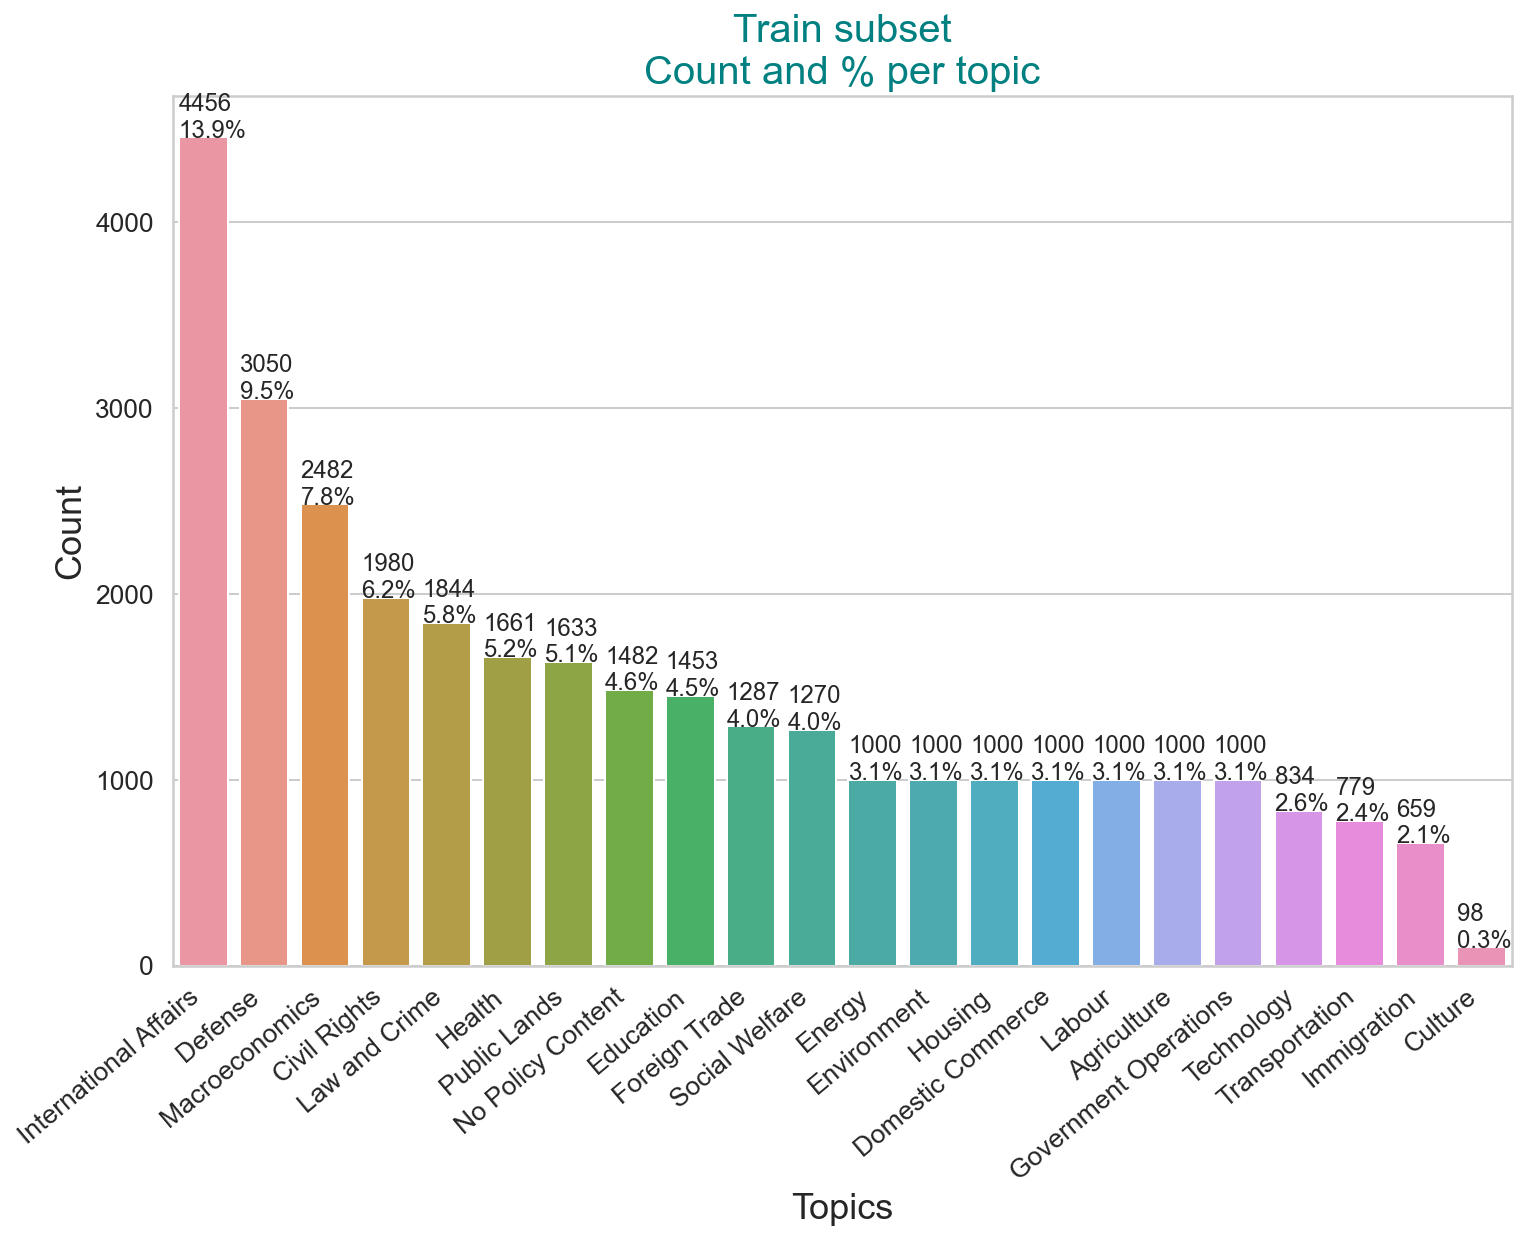

In [26]:

total=df_train.count()[0]
num=[]
percentage=[]
total=df_train.count()[0]
for i in range(len(class_names)):
    a=df_train[df_train.majortopic==i].count()[0]
    num.append(a)
    percentage.append(round(a/total*100,1))
train_counts=pd.DataFrame({"Major_Topic":class_names, "Count":num, "%_of_total":percentage})
sorted_train_counts=train_counts.sort_values("Count",ascending=False)

#And now, the plot:
ax = sns.barplot(x="Major_Topic", y="Count", data=sorted_train_counts)
plt.xlabel('Topics',fontsize =18)
plt.ylabel('Count',fontsize =18)
for p in ax.patches:
    porcentage=p.get_height()/total*100
    txt = str(int(p.get_height()))+"\n" + str((porcentage).round(1)) + "%"
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt, fontsize=12)
plt.title('Train subset\nCount and % per topic', fontsize =20,color="teal")
ax.set_xticklabels(sorted_train_counts.Major_Topic,rotation=40, ha='right');


## Preprocessing


In [27]:
import nltk
nltk.download('stopwords')

def preprocess(df):
  #remove all numbers and symbols
  df['long_description'] = df['long_description'].astype('str').apply(lambda x: re.sub('[^A-Za-z]', ' ', x)) 
  #lowercase
  df['long_description']=df['long_description'].str.lower()
  #remove stopwords
  stop = stopwords.words('english')
  df['long_description'] = df['long_description'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
  #Porter stemming
  porter = PorterStemmer()
  df['long_description'] = df['long_description'].apply(lambda x: ' '.join([porter.stem(word) for word in x.split()]))
  return df

[nltk_data] Downloading package stopwords to C:\Users\Guillermo
[nltk_data]     Fremd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
df_test_original=df_test.copy()

df_train=preprocess(df_train)
df_test=preprocess(df_test)
df_val=preprocess(df_val)

## Vectorisation


In [29]:
#Here I create two functions: one to define the parameters of the vetoriser and fit it with the training data, and then another one to vectorise (transform) data


def generic_vectorizer(min_ngram=1,max_ngram=3,max_features=1500,column=df_train.long_description,max_df=1):
  vec_tfidf = TfidfVectorizer(ngram_range=(min_ngram,max_ngram),max_features=max_features,max_df=max_df)
  vec_tfidf=  vec_tfidf.fit(column)
  return(vec_tfidf)

def vectorise_tfidf(sentences,vectorizer):
     
    dense_tdm = vectorizer.transform(sentences) # dense vectorizer without column names
    tdm = pd.DataFrame(dense_tdm.toarray(), columns=vectorizer.get_feature_names())# sparse matrix with column names
    return tdm


In [52]:

a=True
b=False
best_accuracy=0
for min_ngram in [1]:
  for max_ngram in [2,3,4]:
    for max_features in [4000, 6000, 8000,10000]:
      for alpha in [1,2]:
        for fit_prior in [a,b]:
          for max_df in [0.025, 0.05, 0.1, 0.2]:
            vectorizer=generic_vectorizer(min_ngram=min_ngram,max_ngram=max_ngram,max_features=max_features,column=df_train.long_description,max_df=max_df)


            X_train=vectorise_tfidf(df_train["long_description"],vectorizer)
            X_val=vectorise_tfidf(df_val["long_description"],vectorizer)
            y_train=df_train["majortopic"].astype('int')
            y_val=df_val["majortopic"].astype('int')
            nb = MultinomialNB(fit_prior=fit_prior,alpha=alpha)
            nb.fit(X_train, y_train)
            y_pred = nb.predict(X_val)
            print("min_ngram: ",min_ngram,"max_ngram: ",max_ngram, "max_features: ", max_features, "alpha: ",alpha,"fit_prior: ",fit_prior,"max_df: ",max_df)
            accuracy= metrics.accuracy_score(y_val, y_pred)
            print("total accuracy: ", accuracy)
            print("---------------------")
            if accuracy>best_accuracy:
              best_accuracy=accuracy
              best_parameters={"min_ngram": min_ngram,"max_ngram":max_ngram, "max_features": max_features, "alpha": alpha,"fit_prior":fit_prior,"max_df":max_df}

print("THE BEST PARAMETERS ARE: ",best_parameters )
print("In the validation data they achieve an accuracy of ", best_accuracy)



min_ngram:  1 max_ngram:  2 max_features:  4000 alpha:  1 fit_prior:  True max_df:  0.025
total accuracy:  0.639375168327498
---------------------
min_ngram:  1 max_ngram:  2 max_features:  4000 alpha:  1 fit_prior:  True max_df:  0.05
total accuracy:  0.644223000269324
---------------------
min_ngram:  1 max_ngram:  2 max_features:  4000 alpha:  1 fit_prior:  True max_df:  0.1
total accuracy:  0.6471855642337733
---------------------
min_ngram:  1 max_ngram:  2 max_features:  4000 alpha:  1 fit_prior:  True max_df:  0.2
total accuracy:  0.6504174521949906
---------------------
min_ngram:  1 max_ngram:  2 max_features:  4000 alpha:  1 fit_prior:  False max_df:  0.025
total accuracy:  0.6517640721788311
---------------------
min_ngram:  1 max_ngram:  2 max_features:  4000 alpha:  1 fit_prior:  False max_df:  0.05
total accuracy:  0.6595744680851063
---------------------
min_ngram:  1 max_ngram:  2 max_features:  4000 alpha:  1 fit_prior:  False max_df:  0.1
total accuracy:  0.6673848639

## Evaluation

I will now use the parameters identified as the best both to vectorise the test data and to run the NB model.

In [31]:
vectorizer=generic_vectorizer(min_ngram=1,max_ngram=2,max_features=8000,column=df_train.long_description, max_df=0.1)

X_train=vectorise_tfidf(df_train["long_description"],vectorizer)
X_test=vectorise_tfidf(df_test["long_description"],vectorizer)
y_train=df_train["majortopic"].astype('int')
y_test=df_test["majortopic"].astype('int')

#i am also doing it for the validation, because I will use it later.
X_val=vectorise_tfidf(df_val["long_description"],vectorizer)
y_val=df_val["majortopic"].astype('int')



In [32]:
nb = MultinomialNB(fit_prior=False,alpha=1)
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
accuracy= metrics.accuracy_score(y_test, y_pred)
print(accuracy)

0.6975752731148415


In [33]:
print(classification_report(y_test, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

    No Policy Content       0.66      0.65      0.66       311
       Macroeconomics       0.61      0.76      0.68       264
         Civil Rights       0.58      0.66      0.62       152
               Health       0.76      0.86      0.81       274
          Agriculture       0.67      0.65      0.66        40
               Labour       0.69      0.57      0.62       134
            Education       0.78      0.88      0.83       267
          Environment       0.61      0.69      0.65        85
               Energy       0.82      0.81      0.82        58
          Immigration       0.64      0.55      0.59        38
       Transportation       0.71      0.67      0.69        30
        Law and Crime       0.74      0.59      0.66       331
       Social Welfare       0.70      0.55      0.62       168
              Housing       0.72      0.60      0.65        88
    Domestic Commerce       0.70      0.34      0.46  

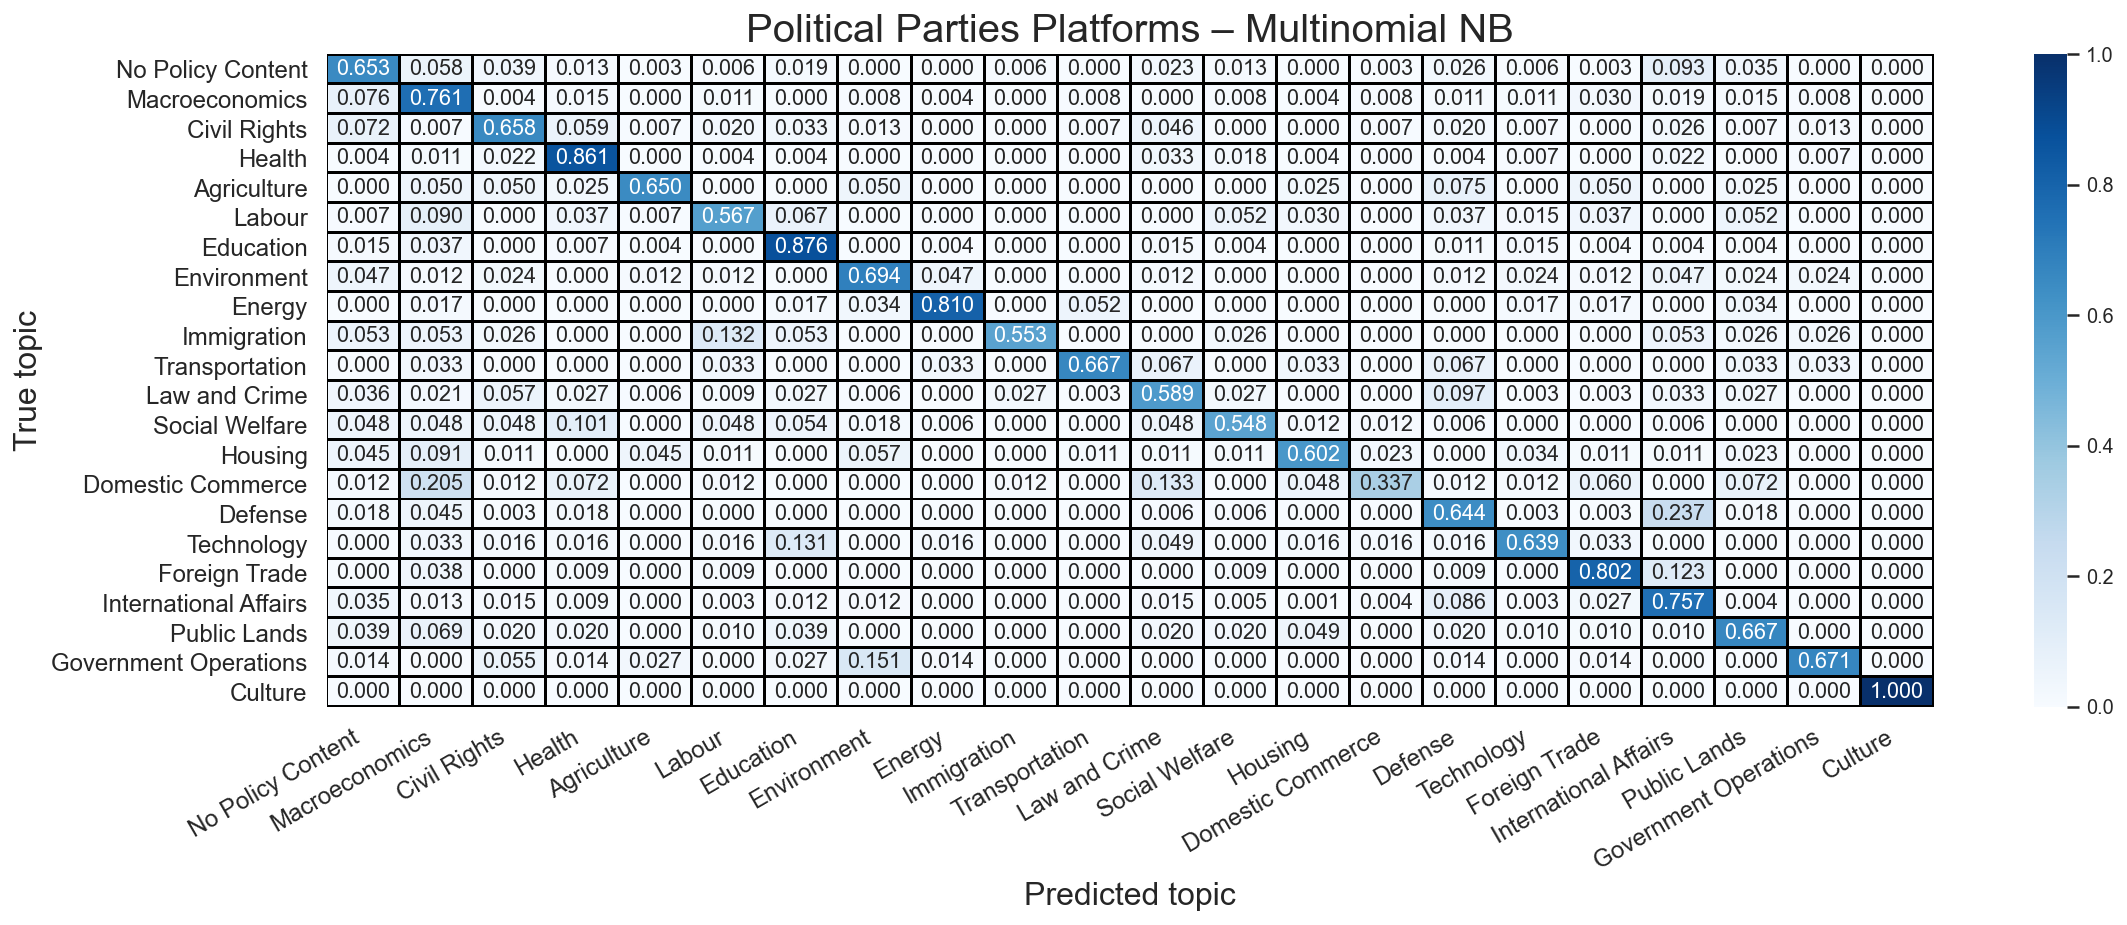

In [34]:
def show_confusion_matrix(confusion_matrix):
  plt.figure(figsize = (18,6))
  sns. set(font_scale=0.9)
  hmap = sns.heatmap(confusion_matrix, annot=True,fmt='.3f', cmap="Blues", linewidths=1, linecolor='black')
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right',size=12)
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right',size=12)
  plt.ylabel('True topic',fontdict={"size":16})
  plt.title('Political Parties Platforms – Multinomial NB', fontsize =20)
  plt.xlabel('Predicted topic',fontdict={"size":16});

cm = confusion_matrix(y_test, y_pred,normalize="true")
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)


In [35]:
df_test.long_description.iloc[2]

'befal us resolv issu anew perhap time centuri come evad issu home'

In [47]:
y_pred[53]

15

In [50]:
#let's see some sentences incorrectly classified from the Domestic Commerce category, as Macroeconomics
for i in range(len(y_test)):
    if y_test.iloc[i]==14:
        if y_pred[i]==1:
            print (df_test_original.long_description.iloc[i])
            print ("---------")

This Administration has violently thrust Federal power into the free market in such areas as steel prices, thus establishing precedents which in future years could critically wound free enterprise in the United States..It has so discouraged private enterprise that the annual increase in the number of businesses has plummeted from the Republican level of 70,000 a year to 47,000 a year.
---------
It has so discouraged private enterprise that the annual increase in the number of businesses has plummeted from the Republican level of 70,000 a year to 47,000 a year..It has allowed the rate of business failures to rise higher under its leadership than in any period since depression days.
---------
The ballooning Bush deficits hijacked capital from productive investments..Savings and loan sharks enriched themselves at their country's expense.
---------
We will provide long-overdue tax relief to families with children..To broaden opportunity, we will support fair lending practices.
---------
Th

In [51]:
#let's see some sentences incorrectly classified from the Domestic Commerce category, as Law and Crime
for i in range(len(y_test)):
    if y_test.iloc[i]==14:
        if y_pred[i]==11:
            print (df_test_original.long_description.iloc[i])
            print ("---------")

An area in special need of more work is liability reform..Frivolous lawsuits put more money in the pockets of trial lawyers and leave businesses with less money to create jobs.
---------
We support efforts by President Bush, Congressional Republicans, and Republican governors to curb the burden of frivolous lawsuits..We recognize that the Democrats√≠¬¥ nominees, one of whom made his fortune as a trial lawyer, are beholden to the interests of the trial lawyer lobby and offer no hope for reform of this badly broken system.
---------
for the first time, an independent board has been established to oversee the accounting profession;.investigators have been given new tools to root out corporate fraud;
---------
The crime of identity theft undermines the basic trust on which our economy depends..And like other forms of stealing, identity theft leaves the victim poorer and feeling terribly violated.
---------
And like other forms of stealing, identity theft leaves the victim poorer and feelin